In [254]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pyogrio

### This dataset provides historical weather data recorded daily at various weather stations worldwide during World War II. 
This allows us to analyze how weather conditions impacted wartime operations and can be useful to understand patterns of the area in the military context and historical weather analysis. 


In [24]:
#Main file with weather info
weather_data = pd.read_csv('Summary of Weather.csv')

#File to recognise the weather station location based on the STA value in the main dataset
stations_data = pd.read_csv('Weather Station Locations.csv')


/var/folders/1_/_d0g9n0d6qg8j72vvxsrnksw0000gn/T/ipykernel_5866/3685655692.py:2: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv('Summary of Weather.csv')


In [8]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  object 
 2   Precip       119040 non-null  object 
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  object 
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SNF          117877 non-

In [25]:
#collection numerical data, excluding useless for the moment collumns
numerical_data = weather_data.select_dtypes(include='number').drop(columns=['STA','FT',
                                                                            'FB','FTI', 'ITH', 'SD3',
                                                                            'RHX', 'RHN', 'RVG', 'WTE', 
                                                                            'SND'])
#selection categorical data and add STA - weather station id
categorical_data = weather_data.select_dtypes(include=['object']).join(weather_data['STA'])

numerical_data.describe()


,WindGustSpd,MaxTemp,MinTemp,MeanTemp,YR,MO,DA,DR,SPD,MAX,MIN,MEA,PGT
count,532.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,533.000000,532.000000,118566.000000,118572.000000,118542.000000,525.000000
mean,37.774534,27.045111,17.789511,22.411631,43.805284,6.726016,15.797530,26.998124,20.396617,81.003745,64.273808,72.644843,12.085333
std,10.297808,8.717817,8.334572,8.297982,1.136718,3.425561,8.794541,15.221732,5.560371,14.869361,14.481498,14.211082,5.731328
min,18.520000,-33.333333,-38.333333,-35.555556,40.000000,1.000000,1.000000,2.000000,10.000000,-28.000000,-37.000000,-32.000000,0.000000
25%,29.632000,25.555556,15.000000,20.555556,43.000000,4.000000,8.000000,11.000000,16.000000,78.000000,59.000000,69.000000,8.500000
50%,37.040000,29.444444,21.111111,25.555556,44.000000,7.000000,16.000000,32.000000,20.000000,85.000000,70.000000,78.000000,11.600000
75%,43.059000,31.666667,23.333333,27.222222,45.000000,10.000000,23.000000,34.000000,23.250000,89.000000,74.000000,81.000000,15.000000
max,75.932000,50.000000,34.444444,40.000000,45.000000,12.000000,31.000000,78.000000,41.000000,122.000000,94.000000,104.000000,23.900000


In [12]:
print(categorical_data.head())

       Date Precip Snowfall PoorWeather  PRCP  SNF TSHDSBRSGF    STA
0  1942-7-1  1.016      0.0         NaN  0.04  0.0        NaN  10001
1  1942-7-2      0      0.0         NaN     0  0.0        NaN  10001
2  1942-7-3   2.54      0.0         NaN   0.1  0.0        NaN  10001
3  1942-7-4   2.54      0.0         NaN   0.1  0.0        NaN  10001
4  1942-7-5      0      0.0         NaN     0  0.0        NaN  10001


Now I separate numerical and categorical variables of the Weather Conditions dataset. Now I have to do the same thing with the Weather Station locations. 

In [14]:
stations_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WBAN              161 non-null    int64  
 1   NAME              161 non-null    object 
 2   STATE/COUNTRY ID  161 non-null    object 
 3   LAT               161 non-null    object 
 4   LON               161 non-null    object 
 5   ELEV              161 non-null    int64  
 6   Latitude          161 non-null    float64
 7   Longitude         161 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 10.2+ KB


In [4]:
num_station = stations_data.select_dtypes(include='number').drop(columns=['WBAN'])
cat_station = stations_data.select_dtypes(include=['object']).join(stations_data['WBAN'])

num_station.describe()

,ELEV,Latitude,Longitude
count,161.000000,161.000000,161.000000
mean,439.850932,20.347205,8.364182
std,1745.422339,21.042992,87.420419
min,1.000000,-27.600000,-175.000000
25%,9.000000,8.233333,-60.850000
50%,27.000000,22.333333,9.083333
75%,98.000000,36.116667,67.250000
max,9999.000000,67.016667,177.366667


In [18]:
print(cat_station.head())

             NAME STATE/COUNTRY ID    LAT     LON   WBAN
0          AIN EL               AL  3623N  00637E  33013
1        LA SENIA               AL  3537N  00037E  33031
2  MAISON BLANCHE               AL  3643N  00314E  33023
3        TELERGMA               AL  3607N  00621E  33044
4         TINDOUF               AL  2741N  00809W  12001


### Now every needed variable is fitted into the proper group (numerical or categorical). And we can focus on the analysis. 

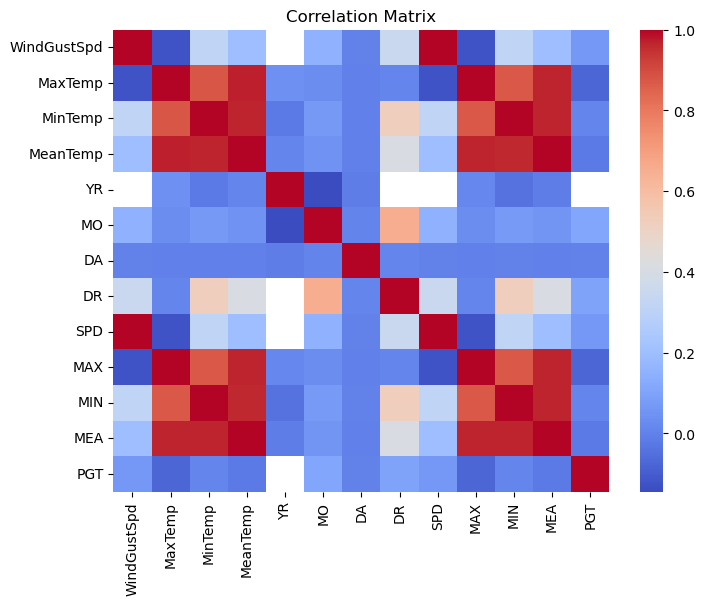

In [22]:
#correlation between plot elements 

data_filtered_corr = numerical_data.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data_filtered_corr, cmap="coolwarm", xticklabels='auto', yticklabels='auto', cbar=True)
ax.set_title('Correlation Matrix')
plt.show()


1. We can observe a big correlation between MaxTemp, MinTemp, MeanTemp and MAX, MIN, MEAN, but its understandable because they present the same data in different scale (Celsius and Fahrenheit) 
2. WindGustSpd (peak wind speed in km/h) and SPD (peak wind speed in knots) the correlation is also obvious, same values in different scales. 
3. Peak wind gust direction in tens of degrees (kierunek skad pochodził najsilniejszy wiatr) is also highly correlated with other variables, especially MO (month of observation), MinTemp, MeanTemp. 
4. The rest variables showed low correlation among each other. 


Mean squared error equals:  0.22876189489087764


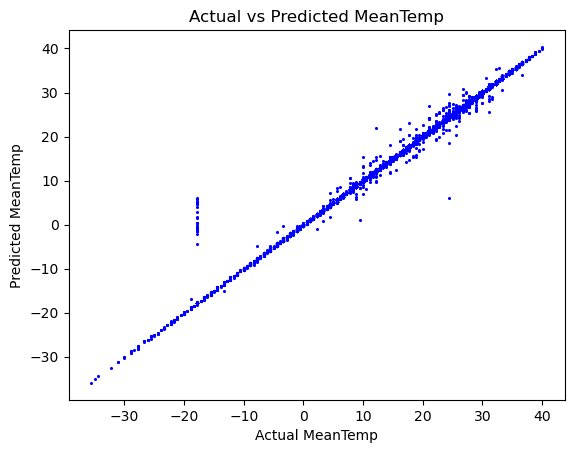

In [53]:
#Linear regression showing how close MeanTemp is to min and max temperature. 
filtered_data_reg1 = numerical_data[['MinTemp', 'MaxTemp', 'MeanTemp']].dropna()
X = filtered_data_reg1[['MinTemp', 'MaxTemp']]
Y = filtered_data_reg1['MeanTemp']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=43)

model = LinearRegression()
_ = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error equals: ", mse)

plt.scatter(y_test, y_pred, color='blue', s=1.5)
plt.xlabel('Actual MeanTemp')
plt.ylabel('Predicted MeanTemp')
plt.title('Actual vs Predicted MeanTemp')
plt.show()


On the plot above we can observe a difference between the actual MeanTemp values and the predicted ones. The mean squared error is low, so we can conclude that this model is pretty accurate. The same thing can be noticed on the actual plot, where most of the values are near y=x plot, which is the ideal one. 

In [55]:
#Mean temp in Paris 
weather_station_id = cat_station[cat_station.NAME == 'PARIS/ORLY'].WBAN

print(weather_station_id)


46    34022
Name: WBAN, dtype: int64


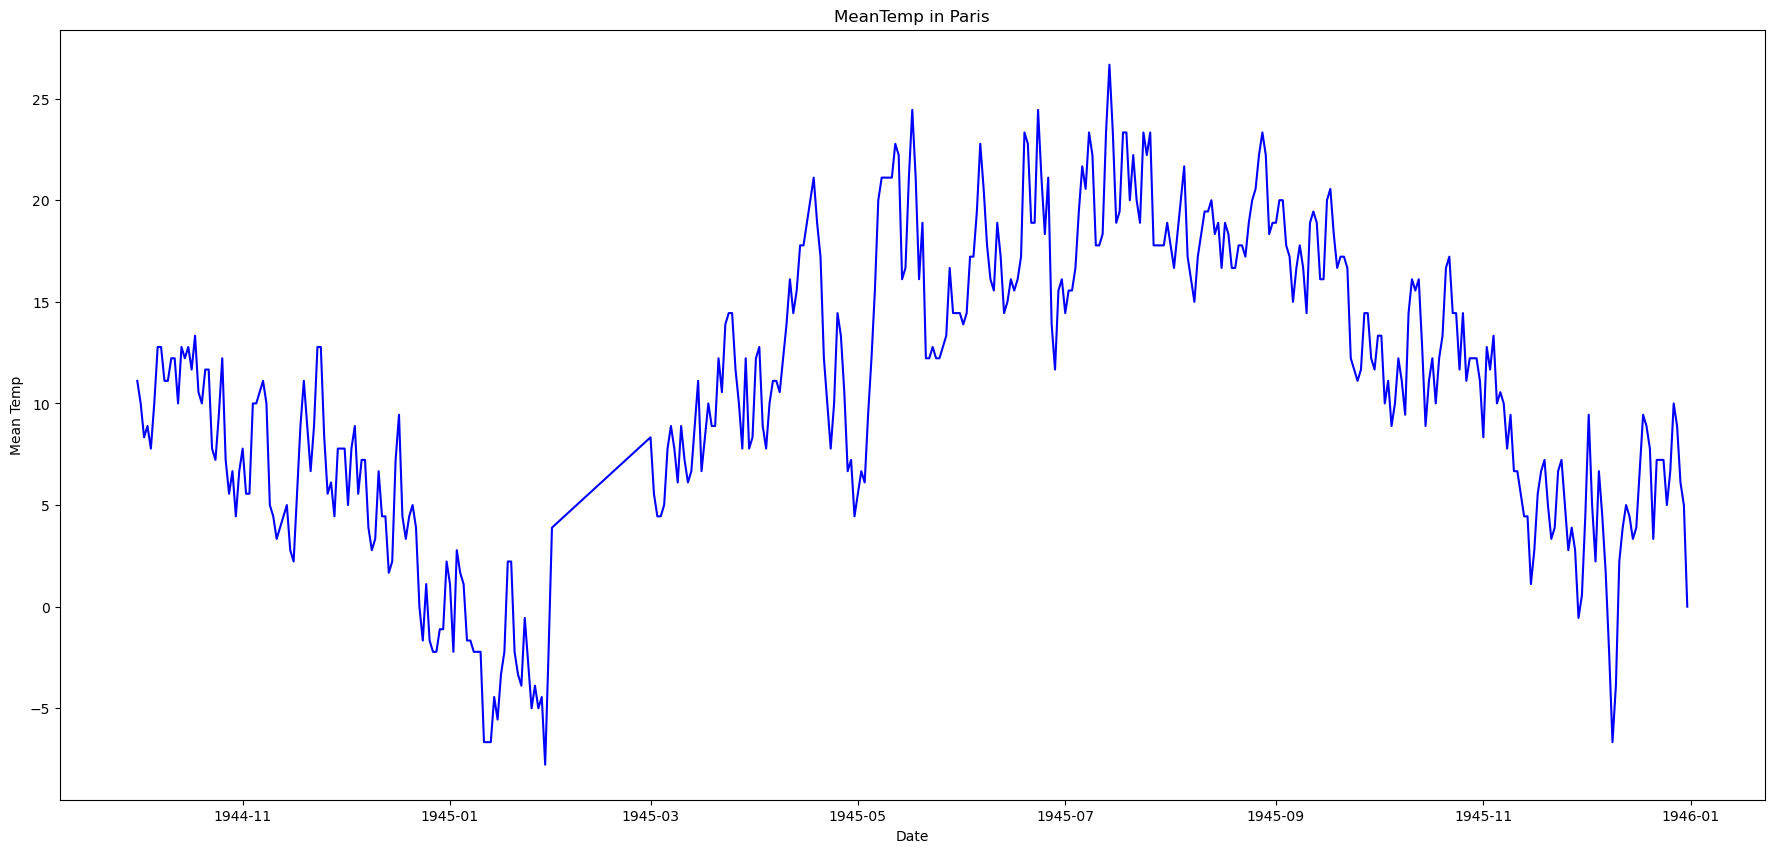

In [72]:
weather_df = weather_data[weather_data.STA == 34022]
weather_df.loc[:, 'Date'] = pd.to_datetime(weather_df['Date'])

plt.figure(figsize=(22, 10))
plt.plot(weather_df['Date'], weather_df['MeanTemp'], color='blue')
plt.xlabel('Date')
plt.ylabel('Mean Temp')
plt.title('MeanTemp in Paris')
plt.show()


In [198]:
#map(pd.Timestamp.toordinal) - allows to convert data to integer number
X_new = weather_df[['Date']].map(pd.Timestamp.toordinal).values.reshape(-1, 1)  # Dodaj .values.reshape(-1, 1)
Y_new = weather_df[['MeanTemp']].values.reshape(-1, 1)

for degree in range(1, 15):
    
    poly = PolynomialFeatures(degree)
    X_order = poly.fit_transform(X_new)
    
    X_train, X_test, y_train, y_test = train_test_split(X_order, Y_new, test_size=0.5, random_state=43)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    R2 = model.score(X_test, y_test)
    print(f"Degree: {degree}, MSE: {mse}, R^2: {R2}")


Degree: 1, MSE: 48.04057776479085, R^2: 0.07154432136271804
Degree: 2, MSE: 41.63145528624767, R^2: 0.1954101538974482
Degree: 3, MSE: 41.62841536729242, R^2: 0.19546890485648982
Degree: 4, MSE: 41.62537252200576, R^2: 0.19552771237124222
Degree: 5, MSE: 41.62232937500975, R^2: 0.195586525716977
Degree: 6, MSE: 41.61928589357661, R^2: 0.19564534552620694
Degree: 7, MSE: 41.61624205960152, R^2: 0.19570417214883495
Degree: 8, MSE: 41.61319791775396, R^2: 0.19576300472155672
Degree: 9, MSE: 41.61015343531768, R^2: 0.19582184387666268
Degree: 10, MSE: 41.60710862148281, R^2: 0.19588068943653958
Degree: 11, MSE: 41.60406348796363, R^2: 0.1959395411747915
Degree: 12, MSE: 41.60101801026811, R^2: 0.19599839956476361
Degree: 13, MSE: 41.59797221112813, R^2: 0.19605726416712854
Degree: 14, MSE: 41.59492607845414, R^2: 0.19611613521553484


As we can notice this model is completely not accurate, so we have to find sth more precise. 

MSE: 10.625982283194437
R^2: 0.791706590713628


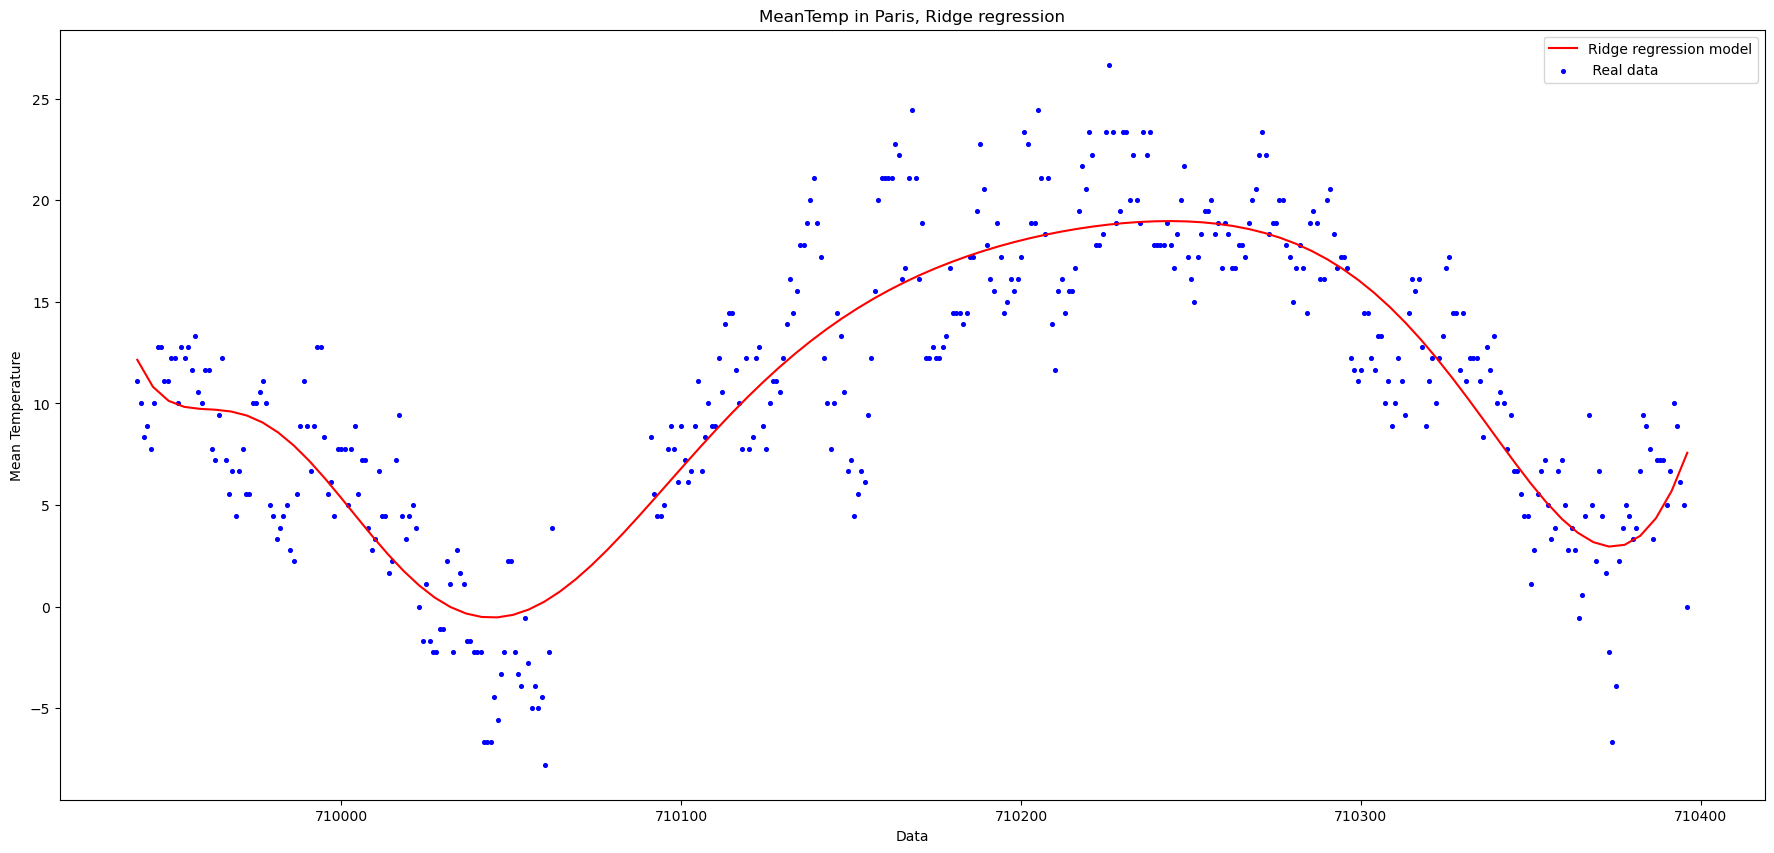

In [199]:
#model for standardisation data - we use this to normalise the values to obtain a higher precision
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)

#poly object is used to give polynomial features
poly = PolynomialFeatures(13, include_bias=False)

#generate a polynomial feature matrix from the normalized features up to the 13th degree
X_order = poly.fit_transform(X_scaled)

#splitting the data - 75% training, 25% testing
X_train, X_test, y_train, y_test = train_test_split(X_order, Y_new, test_size=0.25, random_state=43)

#choose alpha to balance model fit and generalization; 
#higher values reduce overfitting, while lower values increase complexity.
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred)
R2_ridge = ridge.score(X_test, y_test)

print(f"MSE: {mse_ridge}")
print(f"R^2: {R2_ridge}")

#this np.lingspace function allows to create a new smooth range of values from the original one
#in this case our new set has 100 spaced values. reshape is used to create a 2D array (100 rows, 1 column)
X_new_smooth = np.linspace(X_new.min(), X_new.max(), 100).reshape(-1, 1)
X_new_smooth_poly = poly.transform(scaler.transform(X_new_smooth))
y_smooth_pred = ridge.predict(X_new_smooth_poly)

#plot
plt.figure(figsize=(22, 10))
plt.plot(X_new_smooth, y_smooth_pred, color='red', label='Ridge regression model')
plt.scatter(X_new, Y_new, color='blue', s=7, label=' Real data')

plt.xlabel('Data')
plt.ylabel('Mean Temperature')
plt.title('MeanTemp in Paris, Ridge regression')
plt.legend()
plt.show()


Ridge regression is a technique used in linear regression. Regularisation is a statistical method to reduce errors caused by overfitting on training data. Because of that the model is more general and less sensitive. 


1. First of all I normalise the data using StandarScalar to get a higher precision from the model. 
2. I choose 13th degree polynomial, because I believe it matches the data the best and also the mse is acceptable, and R2 is around 80%. 
3. The data was split into training and testing sets with a ratio of 75% for training, 25% for testing. 
4. Alpha in the Ridge model is 0.1. This value was chosen because higher values of alpha resulted in a reduction in accuracy.
5. In the end to present our model I create a new range of values to generate a smooth curve and show it nicely on the plot. 

With MSE: 10, and R2: 0.8 - this model is sufficiently precise for the predicting mean temperature based on the provided data set. 


In [236]:
#Comparing models with each other
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_new)

poly = PolynomialFeatures(13, include_bias=False)
X_order = poly.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_order, Y_new, test_size=0.25, random_state=43)

lasso = Lasso(alpha=0.05, max_iter=1000)
linear = LinearRegression()

linear.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

y_pred_linear = linear.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
R2_linear = linear.score(X_test, y_test)

y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
R2_lasso = lasso.score(X_test, y_test)

print(f"MSE Linear: {mse_linear}, R^2 Linear: {R2_linear}")
print(f"MSE Lasso: {mse_lasso}, R^2 Lasso: {R2_lasso}") 
print(f"MSE Ridge: {mse_ridge}, R^2: {R2_ridge}")



MSE Linear: 9.491906252713033, R^2 Linear: 0.8139370590584251
MSE Lasso: 26.799673031250684, R^2 Lasso: 0.47466548365436434
MSE Ridge: 10.625982283194437, R^2: 0.791706590713628


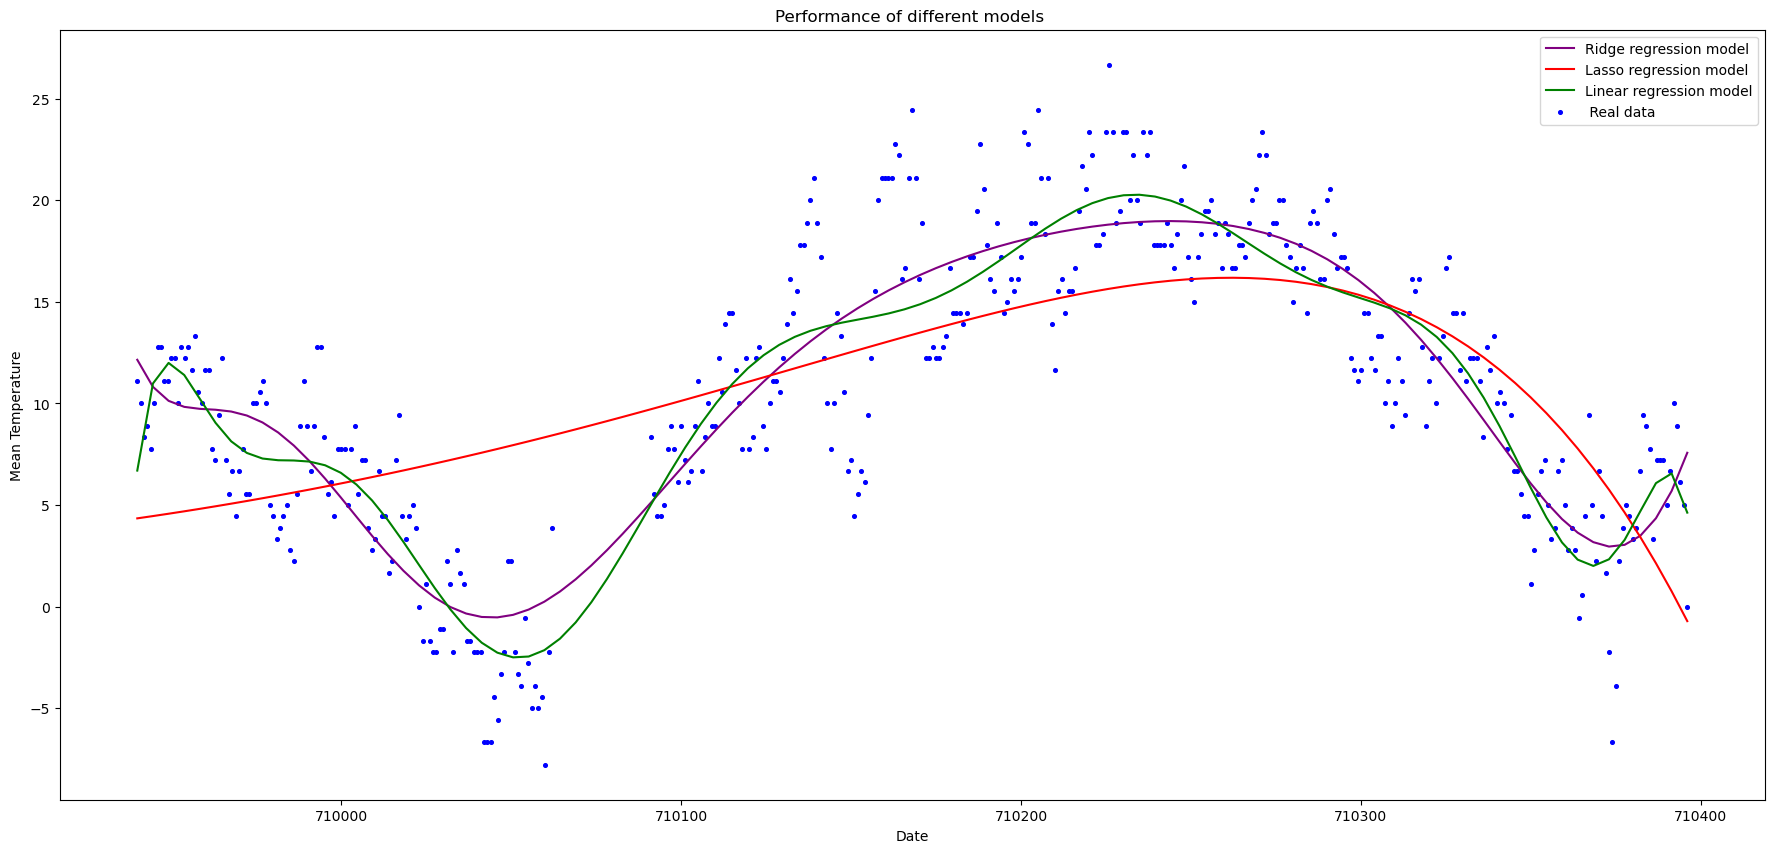

In [248]:
#to create a smooth plot new range
X_new_smooth = np.linspace(X_new.min(), X_new.max(), 100).reshape(-1, 1)
X_new_smooth_poly = poly.transform(scaler.transform(X_new_smooth))
y_smooth_pred_lasso = lasso.predict(X_new_smooth_poly)
y_smooth_pred_linear = linear.predict(X_new_smooth_poly)

#plot
plt.figure(figsize=(22, 10))
plt.plot(X_new_smooth, y_smooth_pred, color='purple', label='Ridge regression model')
plt.plot(X_new_smooth, y_smooth_pred_lasso, color='red', label='Lasso regression model')
plt.plot(X_new_smooth, y_smooth_pred_linear, color='green', label='Linear regression model')
plt.scatter(X_new, Y_new, color='blue', s=7, label=' Real data')

plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Performance of different models ')
plt.legend()
plt.show()


On the plot above we can observe how different regression models perform with our data. Lasso and Ridge are both regularisation techniques applied to linear regression models. Both technique help to prevent overfitting. They help to manage the complexity of the model, leading to better generalization on unseen data.
1. Linear regression - MSE: 9.49, R^2: 0.81 - this have the lowest error, which indicates strong linear relationship. 
2. Lasso - MSE: 26.80, R^2: 0.47 - The error is higher and the accuracy is much lower, so the model is less effective. This model may perform worse in this specific scenario, but might be better in other contexts. 
3. Ridge - MSE: 10.63, R^2: 0.79 - this model error was almost the same as in simple linear approach. 


In [270]:
#Weather station locations across the world 
import geopandas as gpd
import pyogrio

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), engine='pyogrio')

/var/folders/1_/_d0g9n0d6qg8j72vvxsrnksw0000gn/T/ipykernel_5866/1882596333.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), engine='pyogrio')


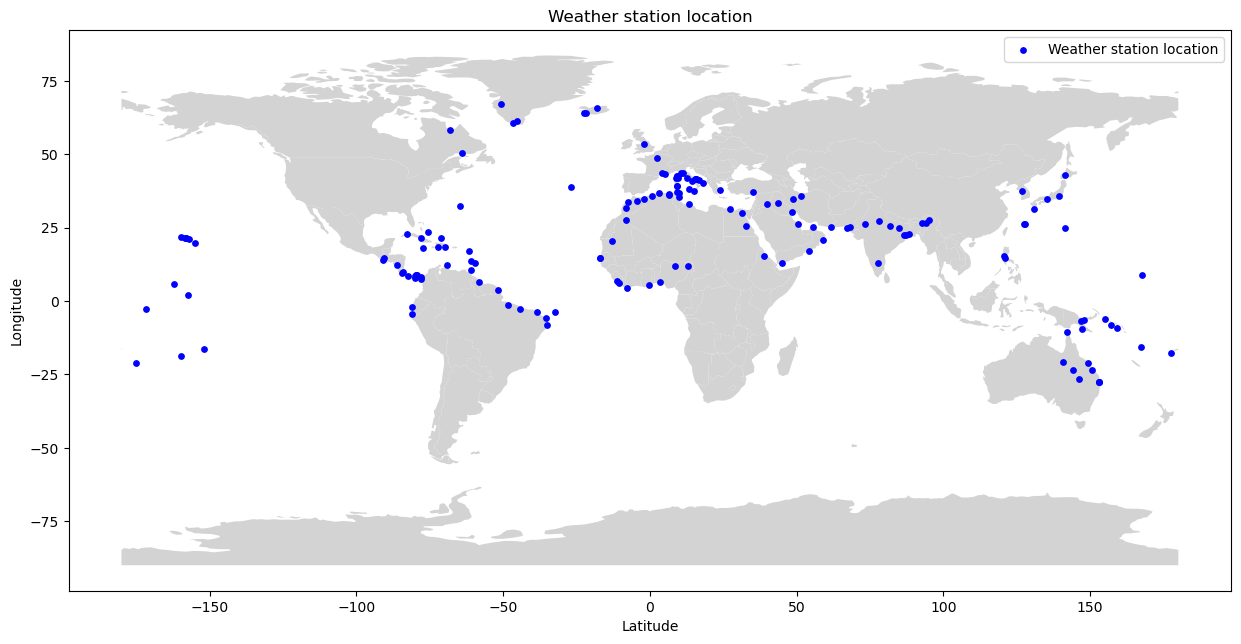

In [286]:
from shapely import Point

geometry = [Point(xy) for xy in zip(stations_data['Longitude'], stations_data['Latitude'])]
gdf = gpd.GeoDataFrame(stations_data, geometry=geometry)

fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, figsize=(20, 20), color='blue', markersize= 15, label='Weather station location')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(loc='upper right')
plt.title("Weather station location")
plt.show()

World map showing the location of the weather stations where values in the dataset were retrieved. 